In [141]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, Gamma, Binomial, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

# for CI testing
assert pyro.__version__.startswith('0.3.2')
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Dataset 

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
   
We will take the logarithm for the response variable GDP as it tends to vary exponentially. We also use a new variable `african_rugged`, defined as the product between the variables `rugged` and `cont_africa`, to capture the correlation between ruggedness and whether a country is in Africa.

In [142]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df["african_rugged"] = data["cont_africa"] * data["rugged"]
df = df[["cont_africa", "rugged", "african_rugged", "rgdppc_2000"]]

In [143]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,african_rugged,rgdppc_2000
2,1,0.858,0.858,7.492609
4,0,3.427,0.000,8.216929
7,0,0.769,0.000,9.933263
8,0,0.775,0.000,9.407032
9,0,2.688,0.000,7.792343
11,0,0.006,0.000,9.212541
12,0,0.143,0.000,10.143191
13,0,3.513,0.000,10.274632
14,0,1.672,0.000,7.852028
15,1,1.780,1.780,6.432380


# Bayesian Linear Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over variables that are consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

## Model

We now have all the ingredients needed to specify our model. First we define priors over weights and bias. Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`.

In [144]:
def model(x_data, y_data):
    # weight and bias priors
    w = pyro.sample("w", Normal(torch.zeros(1, 3), torch.ones(1, 3)).to_event(1))
    b = pyro.sample("b", Normal(0., 1000.))

    precision = pyro.sample("precision", Gamma(1., 1.))
    with pyro.plate("map", len(x_data)):
        prediction_mean = (b + torch.mm(x_data,torch.t(w))).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs", Normal(prediction_mean, 1./torch.sqrt(precision)), obs=y_data)

## Guide

Guide functions must satisfy these two criteria to be valid approximations for a particular model: 
1. all unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. 
2. the guide has the same input signature as the model (i.e., takes the same arguments)

### Full mean field approximation

In [145]:
def guide_mf(x_data=None, y_data=None):
    w_loc = pyro.param("w_loc", torch.zeros(1,3))
    w_scale = pyro.param("w_scale", torch.ones(1,3), constraint=constraints.positive)
    
    b_loc = pyro.param("b_loc", torch.zeros(1,1))
    b_scale = pyro.param("b_scale", torch.ones(1,1), constraint=constraints.positive)
    
    prec_conc = pyro.param("conc", torch.tensor(1.0))
    prec_rate = pyro.param("rate", torch.tensor(1.0))
    pyro.sample("precision", Gamma(prec_conc, prec_rate))

    w = pyro.sample("w", Normal(w_loc, w_scale).to_event(1))
    b = pyro.sample("b", Normal(b_loc, b_scale))
    return {'w': w, 'b': b}

### Generalized mean field approximation

In [150]:
def guide_gmf(x_data=None, y_data=None):
    w_loc = pyro.param("w_loc", torch.zeros(1,3))
    w_scale = pyro.param("w_scale", torch.eye(3), constraint=constraints.lower_cholesky)
    
    b_loc = pyro.param("b_loc", torch.zeros(1,1))
    b_scale = pyro.param("b_scale", torch.ones(1,1), constraint=constraints.positive)
    
    prec_conc = pyro.param("conc", torch.tensor(1.0))
    prec_rate = pyro.param("rate", torch.tensor(1.0))
    pyro.sample("precision", Gamma(prec_conc, prec_rate))
    
    w = pyro.sample("w", MultivariateNormal(loc=w_loc, scale_tril=w_scale))
    b = pyro.sample("b", Normal(b_loc, b_scale))
    return {'w': w, 'b': b}

## Inference

To do inference we'll use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [151]:
# Select the appropriate guide/variational approximation
guide = guide_gmf
pyro.clear_param_store()
optim = Adam({"lr": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=10)

Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  The complete training loop is as follows:

In [152]:
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]
num_iterations = 5000
def train(x_data, y_data):
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train(x_data, y_data)

[iteration 0001] loss: 39.1635
[iteration 0501] loss: 2.8378
[iteration 1001] loss: 1.5207
[iteration 1501] loss: 1.5466
[iteration 2001] loss: 1.4752
[iteration 2501] loss: 1.4964
[iteration 3001] loss: 1.4802
[iteration 3501] loss: 1.6879
[iteration 4001] loss: 1.4660
[iteration 4501] loss: 1.5100


In [154]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

w_loc tensor([[-1.7674, -0.1268,  0.4103]], requires_grad=True)
w_scale tensor([[ 0.1818,  0.0000,  0.0000],
        [ 0.0082,  0.0507,  0.0000],
        [-0.0693, -0.0236,  0.0541]], grad_fn=<ViewBackward>)
b_loc tensor([[9.1936]], requires_grad=True)
b_scale tensor([[0.0794]], grad_fn=<AddBackward0>)
conc tensor(5.5032, requires_grad=True)
rate tensor(5.2231, requires_grad=True)


## Model evaluation

In this case, we'll sample different the regression lines to see how using a Bayesian approach we are able to capture the model undertainty.

In [155]:
def regressionLineSample(x_data, guide):
    return (guide(x_data, y_data)['b'] + torch.mm(x_data,torch.t(guide(x_data, y_data)['w']))).squeeze(-1)

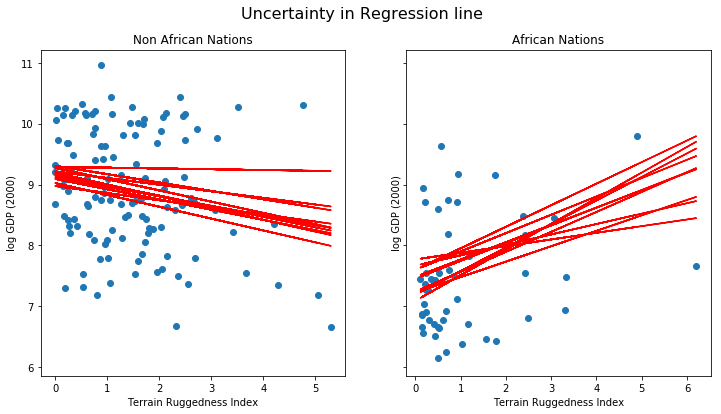

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Uncertainty in Regression line ", fontsize=16)
ax[0].scatter(x_data[x_data[:,0]==0,1].detach().numpy(), y_data[x_data[:,0]==0].detach().numpy())
ax[1].scatter(x_data[x_data[:,0]==1,1].detach().numpy(), y_data[x_data[:,0]==1].detach().numpy())

for i in range(10):
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineSample(x_data[x_data[:,0]==0,:],guide).detach().numpy(), color='r')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineSample(x_data[x_data[:,0]==1,:],guide).detach().numpy(), color='r')

ax[0].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="Non African Nations")
ax[1].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="African Nations")

plt.show()